In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [91]:
# ============= 1. 数据读取与初步处理 =============
data = pd.read_csv('cleaned_data.csv')
print('数据基本信息：')
data.info()

# 提取特征变量x和目标变量y（Ms和Hc）
x = data.drop(columns=['Ms', 'Hc'])
y = data[['Ms', 'Hc']]

# 划分训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Fe            82 non-null     float64
 1   Si            82 non-null     float64
 2   B             82 non-null     float64
 3   Nb            82 non-null     float64
 4   Zr            82 non-null     float64
 5   Cu            82 non-null     float64
 6   Ni            82 non-null     float64
 7   C             82 non-null     float64
 8   P             82 non-null     float64
 9   Co            82 non-null     float64
 10  Gd            82 non-null     float64
 11  Mo            82 non-null     float64
 12  Al            82 non-null     float64
 13  Y             82 non-null     float64
 14  Mn            82 non-null     float64
 15  Cr            82 non-null     float64
 16  Ta            82 non-null     float64
 17  DO3           82 non-null     float64
 18  BCC           82 non-nul

In [92]:
# ============= 2. 使用随机森林进行初始训练并查看性能 =============
# 随机森林同样支持多输出回归，只需将 y 设为 (n_samples, 2) 即可
model = RandomForestRegressor(
    n_estimators=100,    # 也可自行调整
    random_state=42,
    n_jobs=-1            # 并行加速，可选
)
model.fit(x_train, y_train)

# 在测试集上进行预测
y_pred = model.predict(x_test)

# 因为是多输出，所以 y_pred.shape == (len(x_test), 2)
mse_ms = mean_squared_error(y_test['Ms'], y_pred[:, 0])
r2_ms = r2_score(y_test['Ms'], y_pred[:, 0])
mse_hc = mean_squared_error(y_test['Hc'], y_pred[:, 1])
r2_hc = r2_score(y_test['Hc'], y_pred[:, 1])

print(f"初始模型在测试集上的性能：")
print(f"  Ms均方误差(MSE): {mse_ms:.4f}, 决定系数(R²): {r2_ms:.4f}")
print(f"  Hc均方误差(MSE): {mse_hc:.4f}, 决定系数(R²): {r2_hc:.4f}")

初始模型在测试集上的性能：
  Ms均方误差(MSE): 295.6449, 决定系数(R²): 0.8395
  Hc均方误差(MSE): 5888.9820, 决定系数(R²): 0.6990


In [106]:
# 归一化 Ms 和 Hc（使用当前训练集的最小值和最大值）
norm_ms = (y_train['Ms'] - y_train['Ms'].min()) / (y_train['Ms'].max() - y_train['Ms'].min())
norm_hc = (y_train['Hc'] - y_train['Hc'].min()) / (y_train['Hc'].max() - y_train['Hc'].min())

# 定义改进后的复合指标表达式：归一化后的 Ms 减去 lambda 倍归一化后的 Hc
c = norm_ms - lambda_param * norm_hc

# 当前训练集中的最佳复合指标（取最大值）
current_composite = c.max()
print(f"\n初始最佳复合指标（归一化后 Ms - λ*归一化后 Hc）: {current_composite:.4f}")



初始最佳复合指标（归一化后 Ms - λ*归一化后 Hc）: 0.9970


In [107]:
# ============= 4. 加载候选搜索空间（test_data） =============
test_data = pd.read_csv("test_data.csv")
# 确保特征列一致（若有不一致需额外处理）
x_search_all = test_data[x.columns]

In [108]:
# ============= 5. 开始迭代优化 =============
iterations = 10  # 根据需要调整迭代次数
iteration_best = [current_composite]
final_top6_df = None  # 用于保存最后一次迭代中 ie 最大的6个样本

for i in range(iterations):
    print(f"\n========== 迭代 {i+1}/{iterations} ==========")
    # 5.1 从搜索空间中随机采样 100 条
    new_alloys = x_search_all.sample(100, random_state=i)
    
    # 5.2 用当前模型预测候选样本的 Ms 和 Hc
    y_pred_new = model.predict(new_alloys)
    pred_ms = y_pred_new[:, 0]
    pred_hc = y_pred_new[:, 1]
    
    # 5.3 计算候选样本的复合指标 c_hat = Ms^hat - λ * Hc^hat
    c_hat = pred_ms - lambda_param * pred_hc
    
    # 5.4 计算期望改进 Δc = c_hat - current_composite
    delta_c = c_hat - current_composite
    ie = np.where(delta_c > 0, delta_c, 0)  # 只保留正的改进值
    
    # 5.5 选出 ie 最大的 6 个样本
    top6_idx = np.argsort(ie)[-6:]  # 排序后取最后6个索引
    top6_ie = ie[top6_idx]
    
    # 在这 6 个样本中，最优的即 ie 最大的那个
    best_idx_within_top6 = np.argmax(top6_ie)
    best_global_idx = top6_idx[best_idx_within_top6]
    
    best_ms = pred_ms[best_global_idx]
    best_hc = pred_hc[best_global_idx]
    best_ie = ie[best_global_idx]
    
    print(f"  * 本轮最优样本 idx: {best_global_idx}, IE: {best_ie:.4f}")
    print(f"    预测 Ms: {best_ms:.2f}, Hc: {best_hc:.2f}, 复合指标: {c_hat[best_global_idx]:.2f}")
    
    # 5.6 将 ie 最大的 6 个样本都添加到训练集中
    x_train_new = new_alloys.iloc[top6_idx]
    y_train_new = pd.DataFrame({
        'Ms': pred_ms[top6_idx],
        'Hc': pred_hc[top6_idx]
    })
    
    x_train = pd.concat([x_train, x_train_new], ignore_index=True)
    y_train = pd.concat([y_train, y_train_new], ignore_index=True)
    
    # 5.7 重新训练模型
    model.fit(x_train, y_train)
    
    # 5.8 更新当前训练集中复合指标的最大值
    train_composites = y_train['Ms'] - lambda_param * y_train['Hc']
    current_composite = train_composites.max()
    iteration_best.append(current_composite)
    
    print(f"  * 训练集复合指标最大值更新为: {current_composite:.4f}")
    
    # 5.9 打印本轮选出的 6 个样本及其改进信息，并保存为 final_top6_df（最后一次迭代会覆盖前面的）
    df_top6 = new_alloys.iloc[top6_idx].copy()
    df_top6["pred_Ms"] = pred_ms[top6_idx]
    df_top6["pred_Hc"] = pred_hc[top6_idx]
    df_top6["c_hat"]   = c_hat[top6_idx]
    df_top6["ie"]      = ie[top6_idx]
    print("  * 本轮 ie 最大的 6 个样本及其改进值：")
    print(df_top6)
    
    final_top6_df = df_top6.copy()  # 保存最后一轮的 top6


========== 迭代 1/10 ==========
  * 本轮最优样本 idx: 66, IE: 178.3897
    预测 Ms: 194.98, Hc: 31.18, 复合指标: 179.39
  * 训练集复合指标最大值更新为: 223.1243
  * 本轮 ie 最大的 6 个样本及其改进值：
         Fe    Si     B   Nb   Zr   Cu    Ni    C    P    Co  ...  BCC  FCC  \
2932  79.60  3.83  1.42  0.0  0.0  0.0  0.00  0.0  0.0  8.33  ...  0.0  0.0   
5313  72.64  0.00  7.75  0.0  0.0  0.0  5.45  0.0  0.0  7.94  ...  1.0  1.0   
5615  71.54  6.56  6.76  0.0  0.0  0.0  6.84  0.0  0.0  3.15  ...  1.0  0.0   
2398  70.25  7.35  6.70  0.0  0.0  0.0  3.33  0.0  0.0  2.75  ...  0.0  0.0   
5611  75.78  6.68  7.39  0.0  0.0  0.0  1.88  0.0  0.0  0.10  ...  1.0  0.0   
6419  81.37  0.00  2.98  0.3  0.0  0.0  0.00  0.0  0.0  9.51  ...  1.0  1.0   

      HCP  Orthorhombic  hexagonal  Tetragonal     pred_Ms    pred_Hc  \
2932  0.0           0.0        0.0         1.0  190.276261  37.171901   
5313  0.0           1.0        0.0         0.0  175.397833   6.207040   
5615  0.0           1.0        1.0         0.0  175.509394   5.958

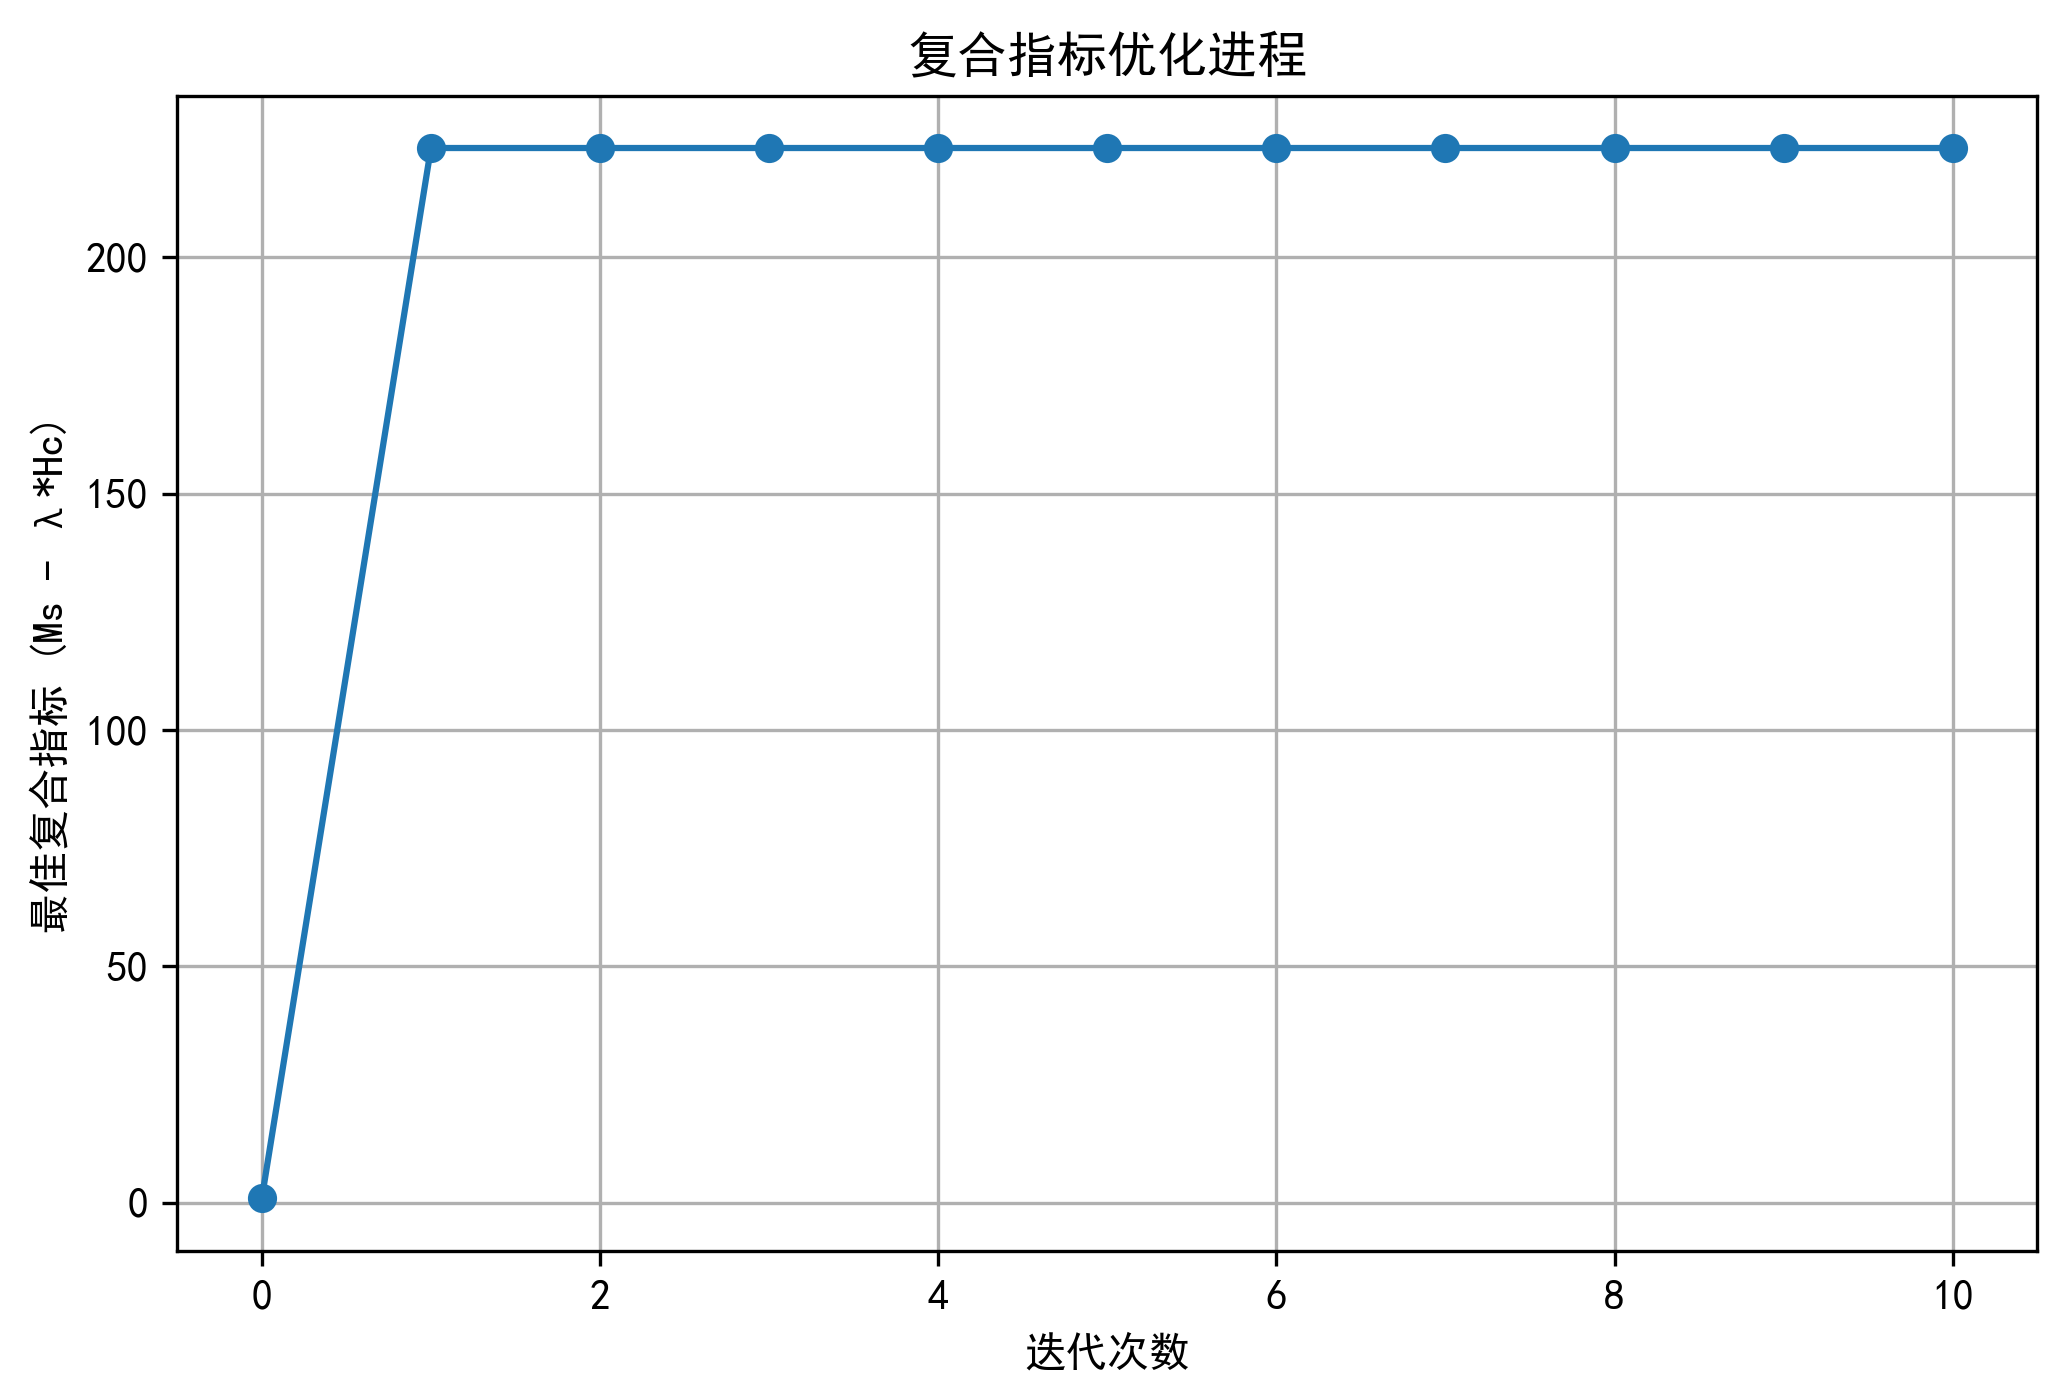

In [109]:
# ============= 6. 可视化迭代过程中 best 的变化 =============
plt.figure(figsize=(8, 5))
plt.plot(range(iterations + 1), iteration_best, marker='o', linestyle='-')
plt.xlabel('迭代次数')
plt.ylabel('最佳复合指标 (Ms - λ*Hc)')
plt.title('复合指标优化进程')
plt.grid(True)
plt.savefig('优化进程.png')
plt.show()

In [110]:
# ============= 7. 输出最终结果 =============
best_idx = np.argmax(y_train['Ms'] - lambda_param * y_train['Hc'])
best_features = x_train.iloc[best_idx]
best_ms_val = y_train.iloc[best_idx]['Ms']
best_hc_val = y_train.iloc[best_idx]['Hc']
best_composite = best_ms_val - lambda_param * best_hc_val

print("\n========== 最终优化结果 ==========")
print("最佳特征组合：")
print(best_features)
print(f"Ms: {best_ms_val:.2f}")
print(f"Hc: {best_hc_val:.2f}")
print(f"复合指标 (Ms - λ*Hc): {best_composite:.2f}")

# ============= 8. 最终输出 ie 最大的 6 个样本 =============
print("\n========== 最终 ie 最大的 6 个样本 ==========")
if final_top6_df is not None:
    print(final_top6_df)
else:
    print("未获取到 ie 最大的 6 个样本信息。")


========== 最终优化结果 ==========
最佳特征组合：
Fe              85.4
Si               0.0
B                1.0
Nb               0.1
Zr               0.0
Cu               0.5
Ni               0.0
C                2.0
P               11.0
Co               0.0
Gd               0.0
Mo               0.0
Al               0.0
Y                0.0
Mn               0.0
Cr               0.0
Ta               0.0
DO3              0.0
BCC              1.0
FCC              0.0
HCP              0.0
Orthorhombic     0.0
hexagonal        0.0
Tetragonal       0.0
Name: 64, dtype: float64
Ms: 225.82
Hc: 5.40
复合指标 (Ms - λ*Hc): 223.12

========== 最终 ie 最大的 6 个样本 ==========
         Fe    Si      B     Nb   Zr   Cu    Ni    C    P    Co  ...  BCC  \
1700  62.90  0.00  14.18  11.39  0.0  0.0  1.08  0.0  0.0  0.00  ...  1.0   
2374  77.44  0.00   0.00   0.00  0.0  0.0  4.54  0.0  0.0  4.21  ...  1.0   
562   71.81  0.00   0.00   0.00  0.0  0.0  8.40  0.0  0.0  5.50  ...  0.0   
9978  76.85  1.19   6.47   4.24  0.0  0.0

In [111]:
# ============= 8. 最终输出 ie 最大的 6 个样本并保存到 Excel 文件 =============
print("\n========== 最终 ie 最大的 6 个样本 ==========")
if final_top6_df is not None:
    print(final_top6_df)
    # 将结果保存到 Excel 文件（文件名可以根据需要调整）
    final_top6_df.to_excel("final_top6.xlsx", index=False)
    print("最终的 6 个样本已保存到 'final_top6.xlsx' 文件中。")
else:
    print("未获取到 ie 最大的 6 个样本信息。")


========== 最终 ie 最大的 6 个样本 ==========
         Fe    Si      B     Nb   Zr   Cu    Ni    C    P    Co  ...  BCC  \
1700  62.90  0.00  14.18  11.39  0.0  0.0  1.08  0.0  0.0  0.00  ...  1.0   
2374  77.44  0.00   0.00   0.00  0.0  0.0  4.54  0.0  0.0  4.21  ...  1.0   
562   71.81  0.00   0.00   0.00  0.0  0.0  8.40  0.0  0.0  5.50  ...  0.0   
9978  76.85  1.19   6.47   4.24  0.0  0.0  0.00  0.0  0.0  0.00  ...  0.0   
4572  84.29  0.00   2.75   0.00  0.0  0.0  4.92  0.0  0.0  2.56  ...  0.0   
4234  83.27  2.63   0.00   0.00  0.0  0.0  2.95  0.0  0.0  0.00  ...  0.0   

      FCC  HCP  Orthorhombic  hexagonal  Tetragonal     pred_Ms     pred_Hc  \
1700  0.0  1.0           0.0        0.0         1.0  161.246977   12.975548   
2374  1.0  0.0           1.0        0.0         0.0  142.530858  319.404518   
562   1.0  0.0           0.0        1.0         1.0  143.453208  312.234438   
9978  1.0  1.0           0.0        1.0         0.0  163.707155   14.471020   
4572  1.0  0.0           0